In [39]:
%matplotlib inline

**This is to be used when approach 1 fails.**

__Mapping Visium's v1 spots onto a whole-slide image__
-

[10X Genomics' Visium (v1) platform](https://www.10xgenomics.com/products/visium-v1-gene-expression) for spatial transcriptomics is optimized for fresh frozen material and allows
profiling 4 tissue regions in a single slide. Each region has an area of 42.25mm<sup>2</sup>, and a snapshot is saved in a so-called "high-resolution" image which accompanies the gene expression
(counts) matrix. Onto the tissue region, a regular mesh of spots is overlaid, and gene expression is measured from each individual spot.
The spot coordinates are relative to the "high resolution" image. For image analysis however, the "high-resolution" image is not enough and one should use, if possible,
a scanned whole slide image.

Here we are concerned with mapping the spot coordinates from Visium's data set onto a whole slide image. This notebook is designed to deal with the case of
["gene expression slide"](cdn.10xgenomics.com/image/upload/v1695772295/support-documents/CG000241_VisiumImagingGuidelinesTN_RevE.pdf) in which 4 square regions with exterior size of
8mm are used to frame the tissue samples. The frame (fiducial frame) is made of specific patterns of (fiducial) points that should facilitate the estimation of the affine
transformation from "high resolution" image space to whole slide image.

In the following, a number of assumptions are made:

- There is a whole slide image (WSI) of the expression slide, with all 4 regions clearlly visible. Ideally, the WSI has been scanned at 40x or 20x. In any case, the format of the image should be compatible with [OpenSlide](https://openslide.org/) to allow processing.
- Each region is represented by a "high resolution" image (as produced by Visium, __called `hires_image.png`__) and 3 specific files (.feather format) containing: the spots coordinates (__`spots.feather`__), expression profile for each spot (__`expression.feather`__), and gene annotation (__`genes.feather`__), respectively.

In [40]:
try:
    import cv2
    cv2.setNumThreads(16)
    import numpy as np
    import itertools
    import matplotlib.pyplot as plt
    import math
    import pandas as pd
    from skimage.measure import label, regionprops
    from skimage.draw import disk as draw_disk, circle_perimeter
    from skimage.exposure import match_histograms, rescale_intensity
    from skimage.metrics import structural_similarity
    from skimage.util import img_as_float32, img_as_ubyte, img_as_uint
    import imageio.v3 as iio
    import orjson as json
    import collections
    from pathlib import Path
    from compass.core import WSI, Px, wsi2hdf5, MRI
    from compass.sample import SampleManager
    import wsitk_annot
    from typing import Union
    import json as pyjson
    import SimpleITK as sitk
except SyntaxWarning(wrn):
    pass  # SyntaxWarning: invalid escape sequence '\|' etc from Mahotas
    

Some helper functions:

In [41]:
def draw_spots(img: np.array, xy: np.array, rd: np.array) -> np.array:
    tmp = img.copy()
    clr = 255 if tmp.ndim == 2 else (0, 128, 255)
    
    for i in range(xy.shape[0]):
        r, c = draw_disk( ( int(xy[i, 1]), int(xy[i, 0]) ), # (row, col), not (x,y)
                          int(rd[i]), shape=tmp.shape )
        tmp[r, c] = clr

    return tmp
    
        
def match_template(
    tmpl: np.ndarray, img: np.ndarray,
    angles: np.ndarray = np.linspace(0, 360, 37),
    scales: np.ndarray = np.linspace(0.8, 1.2, 9)
) -> dict:
    """Find a template image within a larger image using template matching with rotation and scaling.

    Args:
        tmpl: Template image (grayscale) to search for
        img: Larger image (grayscale) to search within
        angles: Array of rotation angles in degrees to test (default: 37 angles from 0 to 360)
        scales: Array of scaling factors to test (default: 9 values from 0.8 to 1.2)

    Returns:
        dict: Dictionary containing best match information with keys:
            - 'score': Correlation coefficient (-1 to 1)
            - 'angle': Best rotation angle in degrees
            - 'scale': Best scaling factor
            - 'loc': (x,y) tuple of top-left corner position in img
    """

    best = {'score': -1.0, 'angle': None, 'scale': None, 'loc': None}

    for scale in scales:
        # resize template
        sz = (int(tmpl.shape[1] * scale), int(tmpl.shape[0] * scale))
        if sz[0] < 4 or sz[1] < 4:  # too small to match
            continue
        scaled = cv2.resize(tmpl, sz, interpolation=cv2.INTER_LINEAR)

        for angle in angles:
            # rotate about its center
            M = cv2.getRotationMatrix2D((sz[0] / 2, sz[1] / 2), angle, 1.0)
            rot = cv2.warpAffine(scaled, M, sz,
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_REPLICATE)

            # template match
            res = cv2.matchTemplate(img, rot, cv2.TM_CCOEFF_NORMED)
            _, score, _, loc = cv2.minMaxLoc(res)

            if score > best['score']:
                best.update({
                    'score': score,
                    'angle': angle,
                    'scale': scale,
                    'loc': loc  # top-left corner in img
                })
    return best  # best transformation


def apply_tx(fixed: sitk.Image, moving: sitk.Image, tx: sitk.Transform):
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(tx)

    out = resampler.Execute(moving)

    return out


def align_patch(fixed: sitk.Image, moving: sitk.Image):
    R = sitk.ImageRegistrationMethod()

    R.SetMetricAsCorrelation()

    R.SetOptimizerAsRegularStepGradientDescent(
        learningRate=2.0,
        minStep=1e-4,
        numberOfIterations=500,
        gradientMagnitudeTolerance=1e-8,
    )
    R.SetOptimizerScalesFromIndexShift()

    tx = sitk.CenteredTransformInitializer(fixed, moving, sitk.Similarity2DTransform())
    R.SetInitialTransform(tx)

    R.SetInterpolator(sitk.sitkLinear)
    
    outTx = R.Execute(fixed, moving)

    out = apply_tx(fixed, moving, outTx)
    return outTx, out

def apply_pretx(im, scale, rotation, shift):

    if scale is not None:
        # rescale:
        sz = (int(im.shape[1] * scale), int(im.shape[0] * scale))
        im = cv2.resize(im, sz, interpolation=cv2.INTER_LINEAR)

    if rotation is not None:
        # rotate CCW:
        rc = [-1, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_CLOCKWISE][rotation // 90] # from angle to CV2 rotation code
        if rc != -1:
            im = cv2.rotate(im, rc)

    if shift is not None:
        # translate
        val = int(im[0,0])
        im  = cv2.copyMakeBorder(im, shift[0], 0, shift[1], 0, cv2.BORDER_CONSTANT, None, val)

    return im


def rotate_ccw_by_90(xy: np.array, angle: float, shape: tuple) -> np.array:
    # xy: [n x 2] coords
    # angle: 90, 180, or 270
    # shape: (height, width): image (field) shape

    h, w = shape
    
    angle = int(round(angle))
    angle = angle % 360
    if angle not in [0, 90, 180, 270]:
        raise RuntimeError("Angle not a multiple of 90 degrees")

    if angle == 0:
        return xy

    x, y = xy[:,0], xy[:,1]

    if angle == 90:
        xy = np.column_stack((y, w-x))
    elif angle == 180:
        xy = np.column_stack((w-x, h-y))
    else: # 270
        xy = np.column_stack((h-y, x))
        
    return xy

__1. Read the patches and the WSI__
---

In [42]:
path_to_hires = [ # paths to hires images from Visium
    "../../SpTx/visium/SN048_A121573_Rep1/",
    "../../SpTx/visium/SN048_A121573_Rep2/",
    "../../SpTx/visium/SN048_A416371_Rep1/",
    "../../SpTx/visium/SN048_A416371_Rep2/",
]

# WSI name:
wsi_name = "../../SpTx/visium/SN048.ndpi" 
wsi_work_mag = 2.5 # 2.5x = 40x/16

# Output/results
dst_folder = "../../SpTx/visium/SN048"

dst_names = [ Path(_n).stem for _n in path_to_hires ]

# Options
save_detailed_registration = False

In [43]:
# Read hi-res images as grey scale, extract the corner regions (1/10 of the image size)
himg_names = [ Path(_n) / "hires_image.png" for _n in path_to_hires ]

himgs = {}
gexp_files = {}  # gene expression files
spot_files = {}  # spots
k = 1
for himg_name, dst in zip(himg_names, dst_names):
    himgs[f'himg{k}'] = {}
    himg = cv2.imread(str(himg_name), cv2.IMREAD_GRAYSCALE)
    himgs[f'himg{k}']['image'] = himg.copy()
    himgs[f'himg{k}']['name'] = dst
    himgs[f'himg{k}']['source'] = str(himg_name)

    gexp_files[f'himg{k}'] = himg_name.parent / "expression.feather"
    spot_files[f'himg{k}'] = himg_name.parent / "spots.feather"

    k += 1

And here are the 4 patches:

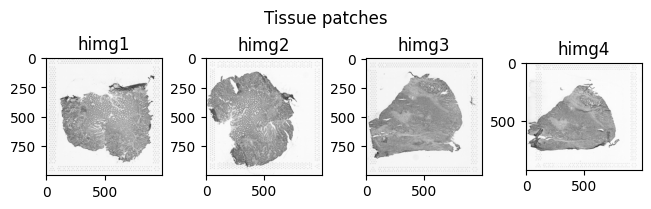

In [44]:
fig, axs = plt.subplots(1, 4, layout='compressed')
fig.suptitle("Tissue patches")
for k in range(4):
    # show them half size
    axs[k].imshow(cv2.resize(himgs[f'himg{k+1}']['image'], None, fx=0.5, fy=0.5), cmap='grey')
    axs[k].set_title(f'himg{k+1}')
plt.show()

The WSI contains 4 regions - we call them 'A', ..., 'D' from left to right:

In [45]:
wsi_slide = WSI(wsi_name)
t_img = wsi_slide.get_plane(wsi_slide.get_level_for_magnification(wsi_work_mag), as_type=np.uint8)
wsi = cv2.cvtColor(t_img, cv2.COLOR_RGB2GRAY)

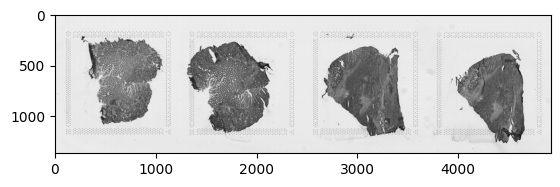

In [46]:
plt.imshow(cv2.resize(wsi, None, fx=0.5, fy=0.5), cmap='grey')

In [47]:
# Split the WSI into 4 parts (A...D):
wsi_h, wsi_w = wsi.shape[:2]
wsi_parts = {
    'A' : wsi[:, 0:wsi_w // 4], 'A_x0': 0, 'A_x1': wsi_w // 4,
    'B' : wsi[:,wsi_w//4:wsi_w//2], 'B_x0': wsi_w//4, 'B_x1': wsi_w // 2,
    'C' : wsi[:,wsi_w//2:3*(wsi_w//4)], 'C_x0': wsi_w//2, 'C_x1': 3*(wsi_w // 4),
    'D' : wsi[:,3*(wsi_w//4):wsi_w], 'D_x0': 3*(wsi_w//4), 'D_x1': wsi_w
}

Check whether the WSI parts are properly separated:

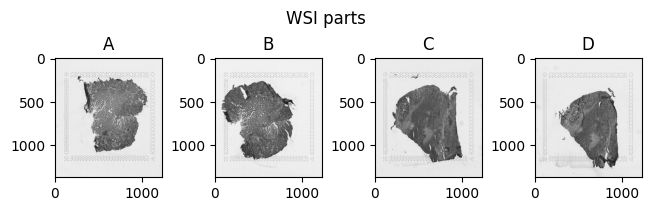

In [48]:
fig, axs = plt.subplots(1, 4, layout='compressed')
fig.suptitle("WSI parts")
k = 0
for p in ['A','B','C','D']:
    # show them half size
    axs[k].imshow(cv2.resize(wsi_parts[p], None, fx=0.5, fy=0.5), cmap='grey')
    axs[k].set_title(p)
    k += 1
plt.show()

__Verify whether the spots are correctly aligned with the high resolution images__

This step helps in confirming that the spot coordinates are correct and using the high resolution image coordinates.

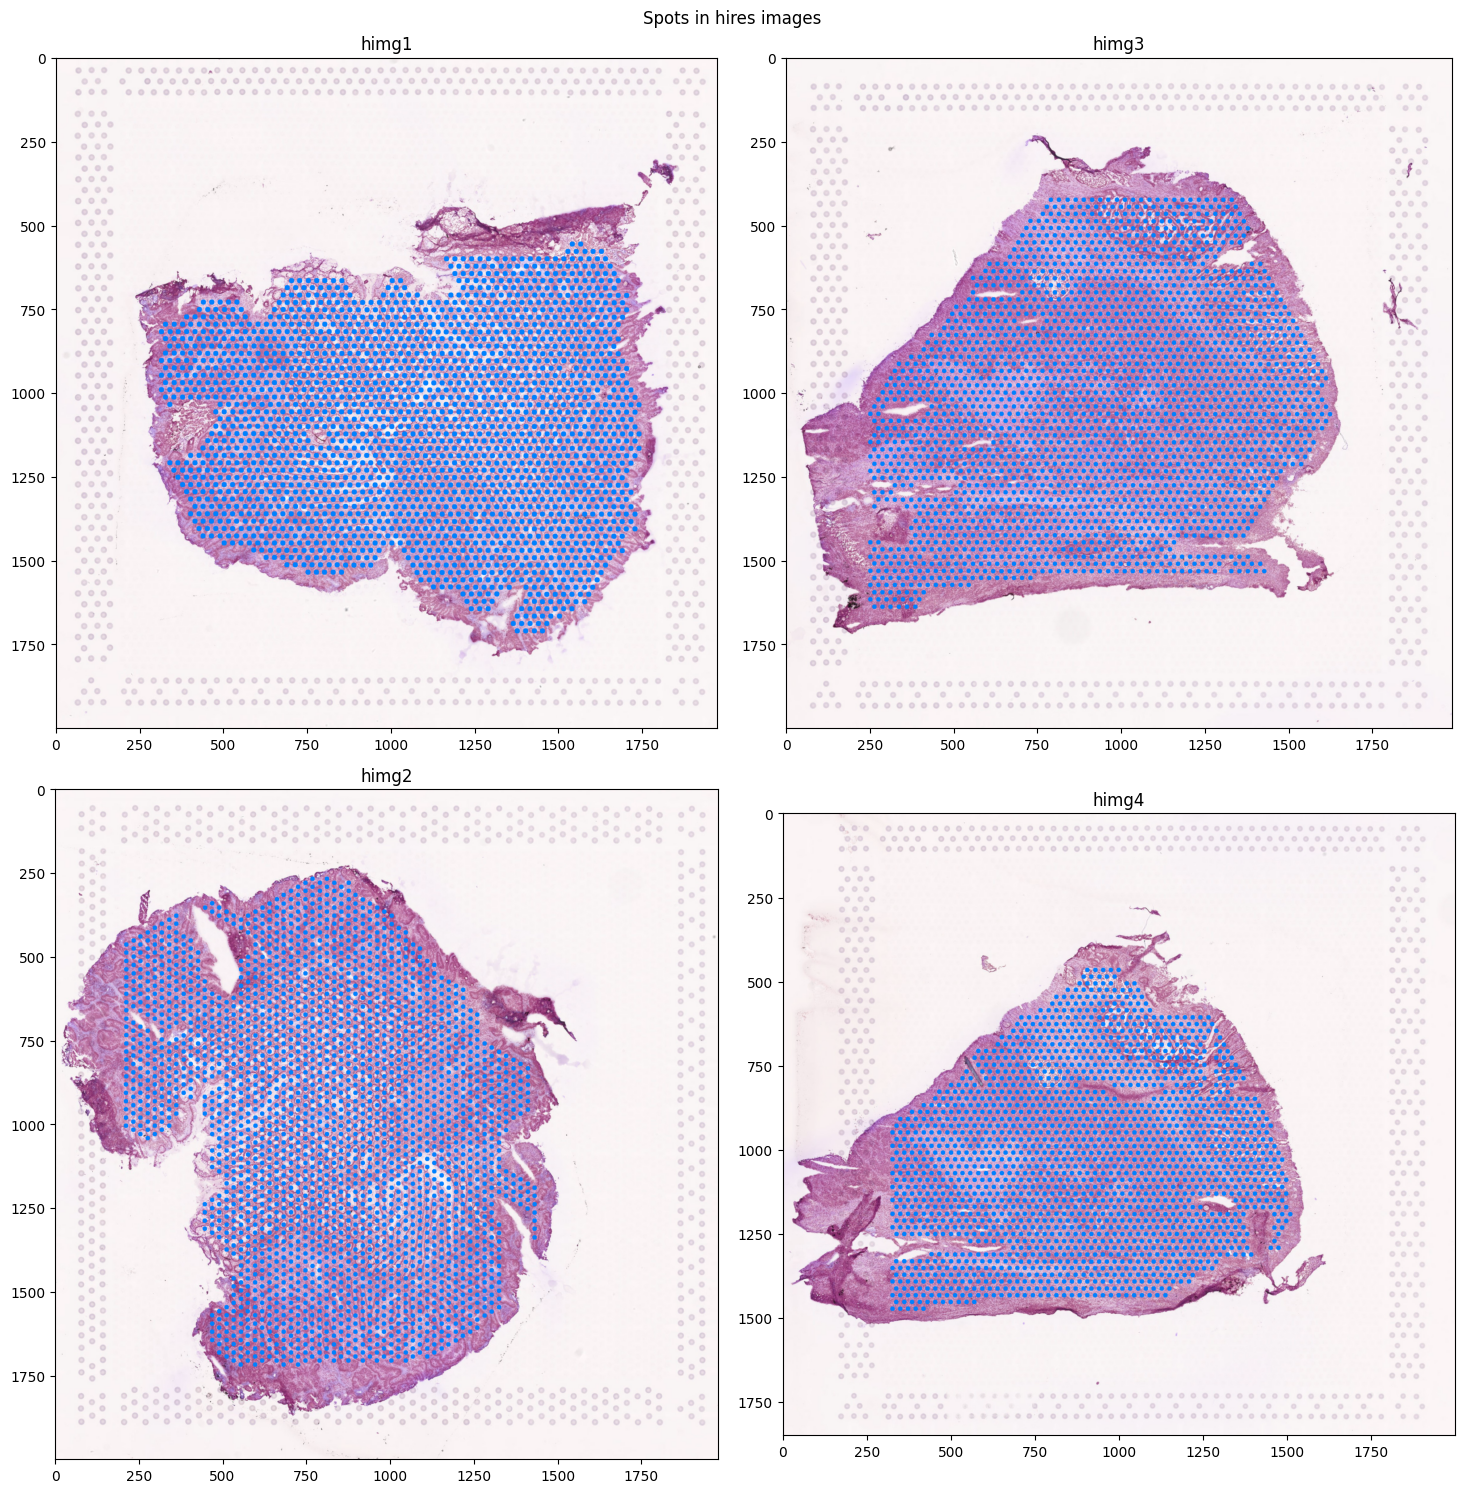

In [49]:
fig, axs = plt.subplots(2, 2, layout='compressed')
fig.suptitle("Spots in hires images")
fig.set_size_inches(15, 15)
k = 0

# Seems like the spot centers are given as (row,column) despite them being called "x" and "y"!!!
for hi in himgs:
    spots = pd.read_feather(spot_files[hi])
    s_xy = spots[["x", "y"]].values    # spot centres
    s_rd = spots[["radius"]].values[:,-1] # just a vector
    n_s = s_xy.shape[0]
    img = draw_spots(
        cv2.imread(str(himgs[hi]['source'])),
        s_xy, s_rd
    )
    axs[k % 2][k // 2].imshow(img)
    axs[k % 2][k // 2].set_title(hi)
    k += 1
plt.show()

__2. Estimate the orientation of the high resolution images__
---

This step uses a simple template matching to
- find the WSI part ('A',...,'D') that corresponds to each high resolution image;
- estimate the scale and rotation (in multiples of 90 degrees) parameters of the transformation mapping the high resolution image to WSI part

The estimate is used to prepare the images for registration, thus ensuring the convergence of the registration step towards the correct solution.

In [50]:
# pre-registration: align hires images to WSI parts
hires_to_wsi = dict()
for hi in himgs:
    hires_to_wsi[hi] = {
        'part': '', 
        'pre-tx': {'score': 0}, 
        'tx': None
    }
    
for hi in himgs:
    for part in ['A','B','C','D']:
        im1 = wsi_parts[part]
        im2 = himgs[hi]['image']

        im2 = np.floor(match_histograms(im2, im1)).astype(np.uint8)
        res = match_template(im2, im1, angles=[0, 90, 180, 270], scales=np.linspace(0.8, 1.2, 21))
        if res['score'] > hires_to_wsi[hi]['pre-tx']['score']:
            hires_to_wsi[hi]['pre-tx'].update(res)
            hires_to_wsi[hi]['part'] = part

Visualize the correspondence between the hires images and WSI parts:

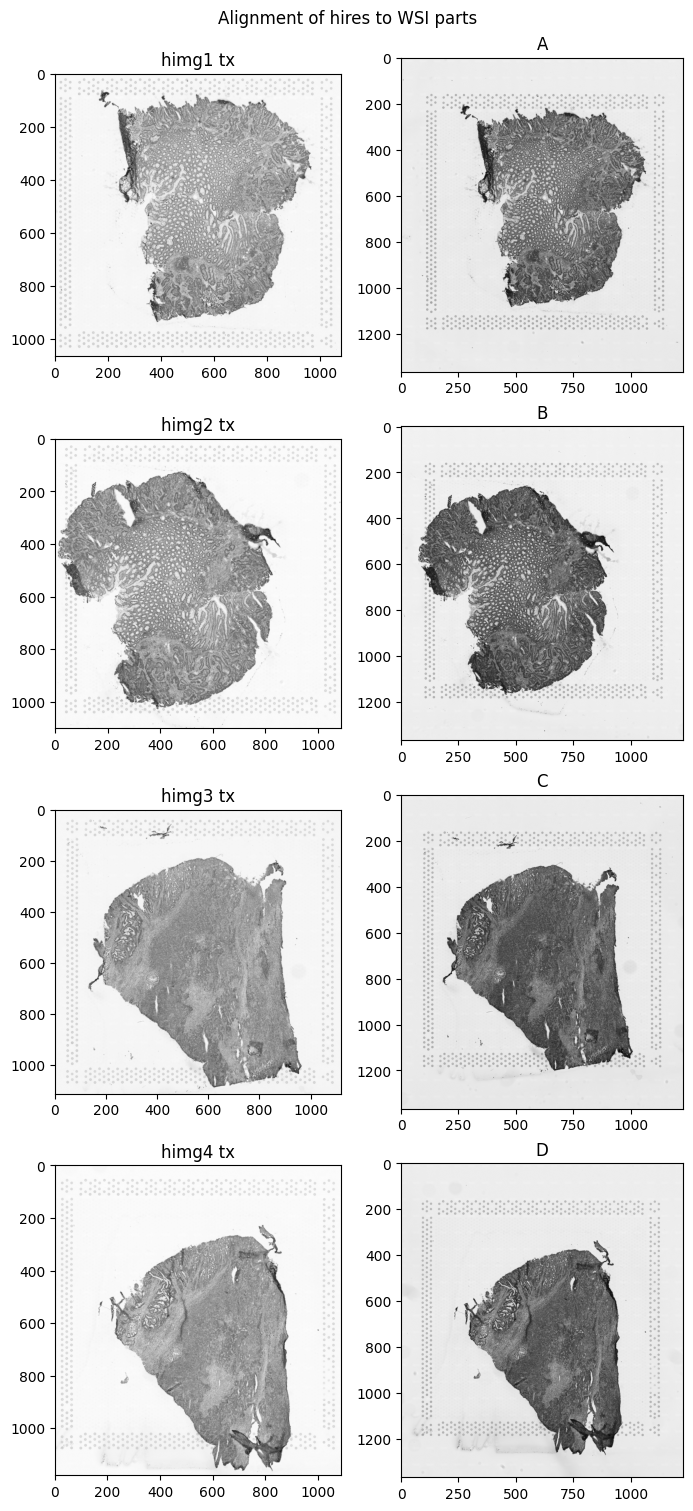

In [51]:
fig, axs = plt.subplots(4, 2, layout='compressed')
fig.suptitle("Alignment of hires to WSI parts")
fig.set_size_inches(15, 15)
i = 0

for i, hi in enumerate(hires_to_wsi):
    im1 = wsi_parts[hires_to_wsi[hi]['part']]
    im2 = himgs[hi]['image']

    im2_tx = apply_pretx(
        im2.copy(), 
        hires_to_wsi[hi]['pre-tx']['scale'], 
        hires_to_wsi[hi]['pre-tx']['angle'], 
        None
    )
    axs[i,0].set_title(f'{hi} tx')
    axs[i,0].imshow(cv2.resize(im2_tx, None, fx=0.5, fy=0.5), cmap='grey')
    axs[i,1].set_title(hires_to_wsi[hi]['part'])
    axs[i,1].imshow(cv2.resize(im1, None, fx=0.5, fy=0.5), cmap='grey')
    

__3. Registration__
---

Use `SimpleITK` to find the registration transformation. Use the previously estimated alignment as initial starting point for the optimization.

In [52]:
# register himgs to the corresponding WSI part
for hi in himgs:
    im1 = wsi_parts[hires_to_wsi[hi]['part']]
    im2 = himgs[hi]['image']

    im2_tx = apply_pretx(
        im2.copy(), 
        hires_to_wsi[hi]['pre-tx']['scale'], 
        hires_to_wsi[hi]['pre-tx']['angle'], 
        None
    )

    tx, _ = align_patch(
        sitk.GetImageFromArray(im1.astype(np.float32)),
        sitk.GetImageFromArray(im2_tx.astype(np.float32))
    )

    hires_to_wsi[hi]['tx'] = tx

Visualize the registration results: tranformed hires images and corresponding WSI parts:

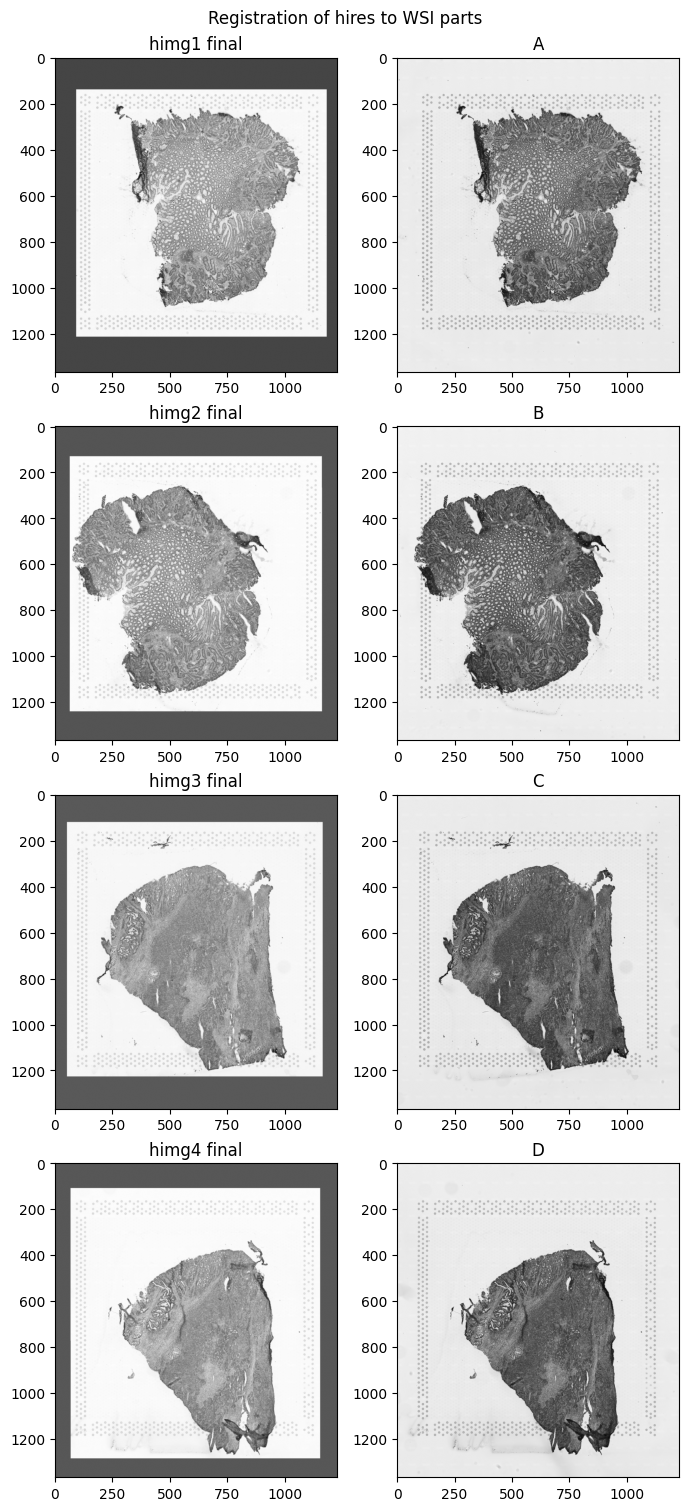

In [53]:
fig, axs = plt.subplots(4, 2, layout='compressed')
fig.suptitle("Registration of hires to WSI parts")
fig.set_size_inches(15, 15)
i = 0

for i, hi in enumerate(hires_to_wsi):
    im1 = wsi_parts[hires_to_wsi[hi]['part']]
    im2 = himgs[hi]['image']

    im2_tx = apply_pretx(
        im2.copy(), 
        hires_to_wsi[hi]['pre-tx']['scale'], 
        hires_to_wsi[hi]['pre-tx']['angle'], 
        None
    )

    im2_tx = apply_tx(
        sitk.GetImageFromArray(im1.astype(np.float32)),
        sitk.GetImageFromArray(im2_tx.astype(np.float32)),
        hires_to_wsi[hi]['tx']
    )
    tmp = img_as_ubyte(rescale_intensity(sitk.GetArrayFromImage(im2_tx), (0, 255)))
    axs[i,0].set_title(f'{hi} final')
    axs[i,0].imshow(cv2.resize(tmp, None, fx=0.5, fy=0.5), cmap='grey')
    axs[i,1].set_title(hires_to_wsi[hi]['part'])
    axs[i,1].imshow(cv2.resize(im1, None, fx=0.5, fy=0.5), cmap='grey')


__4. Transform the spots__
---

Using the transformations estimated above (initial and registration), transform the coordinates of the spots and their radii into the WSI part space.

In [54]:
spots = dict()
for i, hi in enumerate(hires_to_wsi):
    im_h, im_w = himgs[hi]['image'].shape[0:2]   # shape of the hires img
    
    sp  = pd.read_feather(spot_files[hi])
    s_xy = sp[["x", "y"]].values    # spot centres
    s_rd = sp[["radius"]].values[:,-1] # just a vector
    n_spots = len(s_rd)

    s_xy_t = s_xy * hires_to_wsi[hi]['pre-tx']['scale']
    s_rd_t = s_rd * hires_to_wsi[hi]['pre-tx']['scale']
    im_h *= hires_to_wsi[hi]['pre-tx']['scale']
    im_w *= hires_to_wsi[hi]['pre-tx']['scale']
    
    s_xy_t = rotate_ccw_by_90(
        s_xy_t, 
        hires_to_wsi[hi]['pre-tx']['angle'], 
        (im_h, im_w)
    )

    # to estimate the scaling introduce by invTx, a number of np pairs of points
    # are used: the scale factor is computed as the relative change of distance
    # between these pairs.
    n_pairs = 21
    ridx1 = np.random.randint(0, n_spots, n_pairs) # random indexes
    ridx2 = np.random.randint(0, n_spots, n_pairs) # random indexes
    d_preTx = np.linalg.norm(s_xy_t[ridx1, :] - s_xy_t[ridx2, :])
    
    invTx = hires_to_wsi[hi]['tx'].GetInverse()
    s_xy_t = np.array([invTx.TransformPoint(p) for p in s_xy_t])

    d_postTx = np.linalg.norm(s_xy_t[ridx1, :] - s_xy_t[ridx2, :])

    # scf is the estimated scaling transformation:
    scf = np.median([d[1] / d[0] for d in np.column_stack((d_preTx, d_postTx)) if d[0] > 0])

    s_rd_t = s_rd_t * scf  # the radius is re-scaled according to invTx
    
    spots[hi] = {'xy': s_xy_t, 'radius': s_rd_t}

__5. Write the results__
---

The parts of the WSI are saved as separate pyramidal images (stored as HDF5 - see the [COMPASS package](https://github.com/vladpopovici/compass)). The computed affine transformation is used to map the coordinates of the spots from the "high resolution" image coordinates to the corresponding pyramidal image coordinates. The spots are stored as image annotations (each one as a "Circle" object) with gene expression profile as corresponding metadata - see the [WSITK-annot package](https://github.com/vladpopovici/wsitk-annot).

In [55]:
wsi_slide = WSI(wsi_name)
wsi_shape = wsi_slide.shape(level=0)
work_level = wsi_slide.get_level_for_magnification(wsi_work_mag)

for hi in himgs:
    mgr = SampleManager(dst_folder, himgs[hi]['name'], mode="w", overwrite_if_exists=True)

    part_name = hires_to_wsi[hi]['part']
    pp = wsi_slide.convert_px(
        Px(x=wsi_parts[part_name+'_x0'], y=0),
        from_level=work_level,
        to_level=0
    )
    x0 = pp.x
    pp = wsi_slide.convert_px(
        Px(x=wsi_parts[part_name+'_x1'], y=0),
        from_level=work_level,
        to_level=0
    )
    x1 = pp.x
    # write the ROI from WSI into a pyramidal HDF5:
    wsi2hdf5(wsi_name, mgr.get_pyramid_path(0), crop=(x0, 0, x1-x0, wsi_shape.height))


    # process annotations (spots and gene expression)
    expr_data = pd.read_feather(gexp_files[hi])
    n_spots = spots[hi]['xy'].shape[0]
    
    # create the annotation:
    mri = MRI(mgr.get_pyramid_path(0))
    w, h = mri.extent(work_level)
    annot = wsitk_annot.Annotation(
        name="transcriptomics",
        image_shape={'width': w, 'height': h},
        # the initial mpp is at the work_level level:
        mpp = mri.get_mpp_for_level(work_level)
    )
    # Create the corresponding annotations
    genes = expr_data.apply(lambda row: row[row > 0].index.tolist(), axis=1) # detected genes, for each spot (list of lists)

    for k in range(n_spots):
        annot.add_annotation_object(
            wsitk_annot.Circle((spots[hi]['xy'][k,0], spots[hi]['xy'][k,1]), # (x,y)
                               spots[hi]['radius'][k],
                               name=f"spot_{k}",
                               data=expr_data.loc[k, genes[k]].tolist())
        )

    # bring annotation to the highest mpp
    annot.set_resolution(mri.get_mpp_for_level(0))

    # save the annotation
    mgr.add_annotation(annot, 0, "Visium spots")

__6. Verification__
---

Read back data and display low resolution images with spots computed from the annotation.

In [56]:
import gzip

v_imgs = {}  # named list with resulting images
v_level = 5  # level for showing the results

for hi in himgs:
    mri_path = (Path(dst_folder) / himgs[hi]['name']).with_suffix('.cp') / 'pyramid_0.h5'

    # image:
    mri = MRI(mri_path)
    img = np.array( mri.get_plane(v_level , as_type=np.uint8) )

    # annotation
    annot_file = (Path(dst_folder) / himgs[hi]['name']).with_suffix('.cp') / 'annot_0.json.gz'  # annotation for master pyramid (0)
    annot = wsitk_annot.Annotation()
    with gzip.open(annot_file, 'rb') as f:
        annot.load(f)
    # bring annotation to required pyramid level:
    annot.set_resolution( mri.get_mpp_for_level(v_level) )

    # draw just the circles/spots:
    for a in annot._annots['base']:
        if a._annotation_type != "CIRCLE":
            continue
        r, c = draw_disk( ( int(a.center[1]), int(a.center[0]) ), # (row, col), not (x,y)
                          int(a.radius), shape=img.shape )
        img[r, c] = (0, 128, 255)
        v_imgs[hi] = img

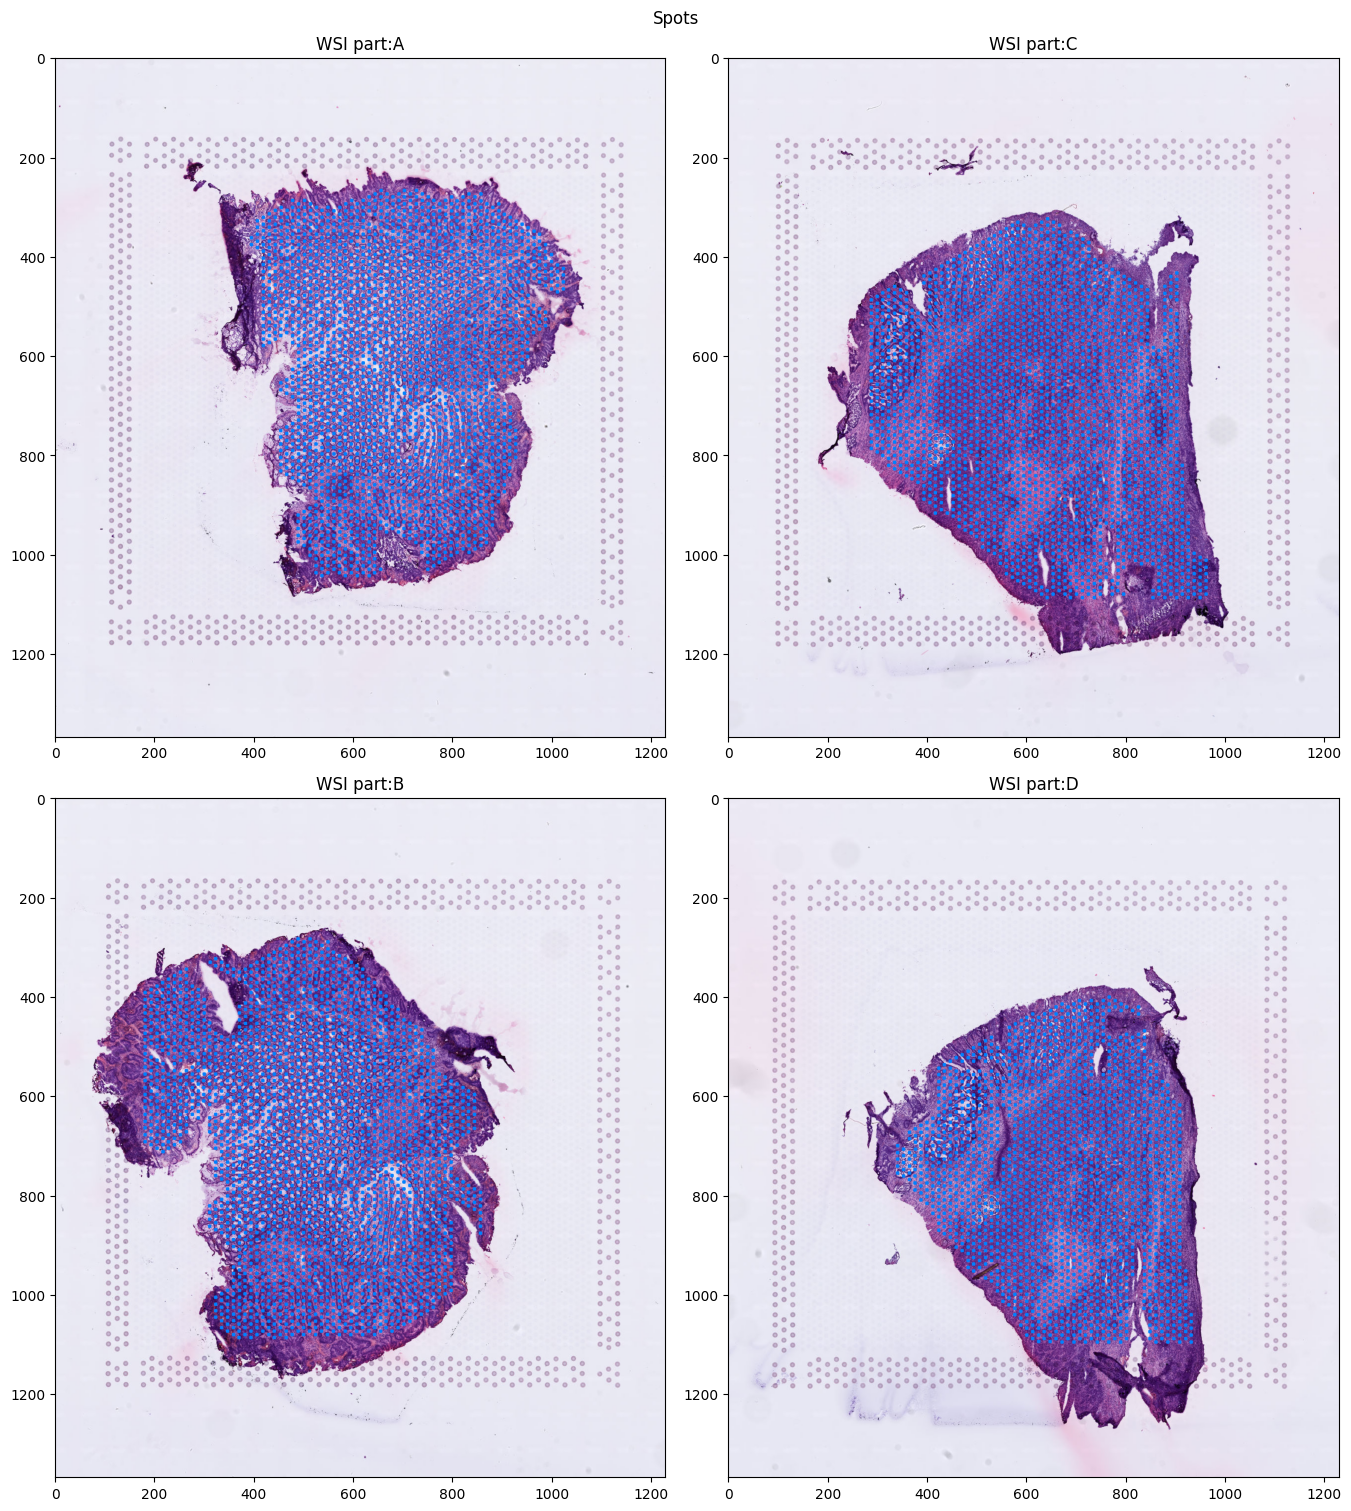

In [57]:
fig, axs = plt.subplots(2, 2, layout='compressed')
fig.suptitle("Spots")
fig.set_size_inches(15, 15)
k = 0
for im in v_imgs:
    # show them half size
    axs[k % 2][k // 2].imshow(v_imgs[im])
    axs[k % 2][k // 2].set_title("WSI part:" + hires_to_wsi[im]['part'])
    k += 1
plt.show()